<a href="https://colab.research.google.com/github/aleanaliaaustral-web/labo2025v/blob/main/Arbol%20gridsearch%20consolidado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ============================================
# Árbol de Regresión: Predecir ganancia_test
# Dataset Consolidado con 10 grupos
============================================

In [1]:
# IMPORTANTE: Primero ejecuta esto en una celda de Python en Colab:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Limpio la memoria
rm(list=ls(all.names=TRUE))
gc(full=TRUE, verbose=FALSE)

# Cargo las librerías necesarias
require("data.table")
require("rpart")
if (!require("rpart.plot")) install.packages("rpart.plot")
require("rpart.plot")

# Carpeta de trabajo
# Usar el directorio actual o crear uno nuevo
experimento <- "KA2004_ArbolGridSearchConsolidado"
if (!dir.exists(experimento)) {
  dir.create(experimento, showWarnings=FALSE)
}
setwd(experimento)

cat("Directorio de trabajo:", getwd(), "\n\n")


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,657390,35.2,1454468,77.7,1393246,74.5
Vcells,1220587,9.4,8388608,64.0,1975128,15.1


Loading required package: data.table

Loading required package: rpart

Loading required package: rpart.plot

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘rpart.plot’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: rpart.plot



Directorio de trabajo: /content/KA2004_ArbolGridSearchConsolidado 



In [3]:
# ============================================
# LECTURA DE DATOS
# ============================================

cat("============================================\n")
cat("ÁRBOL DE REGRESIÓN SOBRE GRID SEARCH CONSOLIDADO\n")
cat("============================================\n\n")

# Leo el dataset desde Google Drive
# Ruta en Google Drive: My Drive > labo1 > datasets > Consolidado gridsearch final_csv.csv
archivo_csv <- "/content/drive/MyDrive/labo1/datasets/Consolidado gridsearch final_csv.csv"

# Verificar que el archivo existe
if (!file.exists(archivo_csv)) {
  cat("ERROR: No se encuentra el archivo:", archivo_csv, "\n")
  cat("Directorio actual:", getwd(), "\n")
  cat("\nAsegúrate de haber montado Google Drive ejecutando:\n")
  cat("  from google.colab import drive\n")
  cat("  drive.mount('/content/drive')\n")
  stop("Por favor, monta Google Drive primero")
}

dataset <- fread(archivo_csv,
                 sep = ";",      # Delimitador punto y coma
                 dec = ".",      # Decimal con punto
                 header = TRUE)

# Limpiar nombres de columnas (quitar espacios)
setnames(dataset, trimws(names(dataset)))

cat("Dataset leído correctamente!\n")
cat("Dimensiones:", nrow(dataset), "filas x", ncol(dataset), "columnas\n")
cat("Columnas:", paste(names(dataset), collapse=", "), "\n\n")

# IMPORTANTE: Limpiar la columna semilla
# Verificar si hay valores no numéricos en semilla
cat("Limpiando columna 'semilla'...\n")
semillas_unicas <- unique(dataset$semilla)
cat("Valores únicos en semilla antes de limpiar:", length(semillas_unicas), "\n")

# Convertir semilla a numérico (los no numéricos se vuelven NA)
dataset[, semilla := as.numeric(as.character(semilla))]

# Eliminar filas con semillas no válidas (NA)
filas_antes <- nrow(dataset)
dataset <- dataset[!is.na(semilla)]
filas_despues <- nrow(dataset)

if (filas_antes > filas_despues) {
  cat("⚠️  Se eliminaron", filas_antes - filas_despues, "filas con semillas no válidas (nombres)\n")
}

cat("Valores únicos en semilla después de limpiar:", length(unique(dataset$semilla)), "\n")
cat("Semillas válidas:", paste(sort(unique(dataset$semilla)), collapse=", "), "\n\n")

# Verificar estructura
cat("Estructura de los datos:\n")
str(dataset)

# Resumen estadístico de ganancia_test
cat("\n\nResumen de ganancia_test:\n")
cat("  Mínimo:  ", format(min(dataset$ganancia_test), big.mark=","), "\n")
cat("  Máximo:  ", format(max(dataset$ganancia_test), big.mark=","), "\n")
cat("  Media:   ", format(mean(dataset$ganancia_test), big.mark=","), "\n")
cat("  Mediana: ", format(median(dataset$ganancia_test), big.mark=","), "\n")
cat("  Desv.Est:", format(sd(dataset$ganancia_test), big.mark=","), "\n\n")

# Resumen por grupo
cat("Resumen por Grupo:\n")
resumen_grupos <- dataset[, .(
  n = .N,
  ganancia_media = mean(ganancia_test),
  ganancia_max = max(ganancia_test),
  ganancia_min = min(ganancia_test)
), by = Grupo]

print(resumen_grupos)


ÁRBOL DE REGRESIÓN SOBRE GRID SEARCH CONSOLIDADO

Dataset leído correctamente!
Dimensiones: 14473 filas x 7 columnas
Columnas: semilla, cp, maxdepth, minsplit, minbucket, ganancia_test, Grupo 

Limpiando columna 'semilla'...
Valores únicos en semilla antes de limpiar: 40 


Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”


⚠️  Se eliminaron 834 filas con semillas no válidas (nombres)
Valores únicos en semilla después de limpiar: 35 
Semillas válidas: 100007, 100009, 100027, 100109, 100151, 101581, 120539, 123457, 127117, 150001, 152843, 187049, 200003, 205151, 206262, 217573, 238883, 245681, 304879, 340649, 345221, 378821, 500009, 533317, 540347, 545599, 555221, 700001, 722899, 813697, 910583, 943153, 947621, 964333, 982451 

Estructura de los datos:
Classes ‘data.table’ and 'data.frame':	13639 obs. of  7 variables:
 $ semilla      : num  5e+05 5e+05 5e+05 5e+05 5e+05 ...
 $ cp           : num  -1 -0.5 -1 -0.5 -1 -0.5 -1 -0.5 -1 -0.5 ...
 $ maxdepth     : int  14 14 14 14 14 14 14 14 14 14 ...
 $ minsplit     : num  30 30 50 50 30 30 30 30 100 100 ...
 $ minbucket    : int  20 20 20 20 17 17 5 5 20 20 ...
 $ ganancia_test: num  27730000 27730000 29860000 29860000 30220000 ...
 $ Grupo        : int  1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


Resumen de ganancia_test:
  Mínimo

In [ ]:
# ============================================
# PARTICIÓN TRAIN/TEST
# ============================================

cat("\n\n============================================\n")
cat("PARTICIÓN DE DATOS\n")
cat("============================================\n\n")

# Con un dataset grande uso 70% train, 30% test
# CAMBIA AQUÍ TU SEMILLA:
SEMILLA <- 500009  # Puedes usar cualquier número entero
set.seed(SEMILLA)
cat("Usando semilla:", SEMILLA, "\n")
n_total <- nrow(dataset)
n_train <- round(0.7 * n_total)

indices_train <- sample(1:n_total, n_train)

dtrain <- dataset[indices_train]
dtest <- dataset[-indices_train]

cat("Partición de datos:\n")
cat("  Train:", nrow(dtrain), "filas (", round(100*nrow(dtrain)/n_total), "%)\n")
cat("  Test: ", nrow(dtest), "filas (", round(100*nrow(dtest)/n_total), "%)\n\n")




PARTICIÓN DE DATOS

Usando semilla: 500009 
Partición de datos:
  Train: 9547 filas ( 70 %)
  Test:  4092 filas ( 30 %)



In [ ]:
# ============================================
# HIPERPARÁMETROS DEL ÁRBOL
# ============================================

cat("============================================\n")
cat("HIPERPARÁMETROS DEL ÁRBOL\n")
cat("============================================\n\n")

# Para un dataset grande (14K+ filas) uso parámetros más robustos
param_arbol <- list(
  "cp" = 0.0001,      # Complejidad muy baja para permitir más splits
  "minsplit" = 20,    # Mínimo de observaciones para split
  "minbucket" = 10,   # Mínimo en hojas terminales
  "maxdepth" = 10     # Profundidad moderada-alta
)

cat("Hiperparámetros del árbol:\n")
cat("  cp:        ", param_arbol$cp, "\n")
cat("  minsplit:  ", param_arbol$minsplit, "\n")
cat("  minbucket: ", param_arbol$minbucket, "\n")
cat("  maxdepth:  ", param_arbol$maxdepth, "\n\n")


HIPERPARÁMETROS DEL ÁRBOL

Hiperparámetros del árbol:
  cp:         1e-04 
  minsplit:   20 
  minbucket:  10 
  maxdepth:   10 



In [ ]:
# ============================================
# ENTRENAMIENTO DEL MODELO
# ============================================

cat("============================================\n")
cat("ENTRENANDO MODELO...\n")
cat("============================================\n\n")

# Modelo de regresión: predigo ganancia_test a partir de hiperparámetros
# Incluye SEMILLA como variable predictora
modelo <- rpart(
    formula = "ganancia_test ~ semilla + cp + maxdepth + minsplit + minbucket",
    data = dtrain,
    method = "anova",  # Regresión
    xval = 10,         # Cross-validation con 10 folds
    control = param_arbol
)

cat("Modelo entrenado con las variables:\n")
cat("  - semilla\n")
cat("  - cp\n")
cat("  - maxdepth\n")
cat("  - minsplit\n")
cat("  - minbucket\n\n")

# Información del modelo
print(modelo)

# Importancia de variables
if (!is.null(modelo$variable.importance)) {
  cat("\n\nImportancia de variables:\n")
  print(sort(modelo$variable.importance, decreasing = TRUE))
}

# Tabla de complejidad
cat("\n\nTabla de complejidad (CP):\n")
printcp(modelo)

ENTRENANDO MODELO...

Modelo entrenado con las variables:
  - semilla
  - cp
  - maxdepth
  - minsplit
  - minbucket

n= 9547 

node), split, n, deviance, yval
      * denotes terminal node

   1) root 9547 3.104463e+17 45712380  
     2) cp>=0.00055 83 2.634567e+16 11686990  
       4) semilla>=539458 66 1.008774e+16  4591515  
         8) minsplit>=75 45 0.000000e+00        0 *
         9) minsplit< 75 21 7.106144e+15 14430480 *
       5) semilla< 539458 17 3.475281e+13 39234120 *
     3) cp< 0.00055 9464 1.871665e+17 46010780  
       6) maxdepth>=11.5 2611 5.818881e+16 43478040  
        12) minsplit< 150 796 1.956041e+16 39946110  
          24) minbucket< 63 607 1.549222e+16 38835210  
            48) minsplit< 40 194 3.954538e+15 35091240  
              96) minbucket< 8 71 1.568312e+15 32208310  
               192) maxdepth>=13 35 6.387407e+14 29300860  
                 384) semilla< 203132.5 19 2.082231e+14 27454210 *
                 385) semilla>=203132.5 16 2.887852e+14 3

In [ ]:
# ============================================
# PODA DEL ÁRBOL (OPCIONAL)
# ============================================

cat("\n\n============================================\n")
cat("ANÁLISIS DE PODA\n")
cat("============================================\n\n")

# Encontrar el mejor CP basado en xerror
mejor_cp_idx <- which.min(modelo$cptable[, "xerror"])
mejor_cp <- modelo$cptable[mejor_cp_idx, "CP"]

cat("Mejor CP según cross-validation:", mejor_cp, "\n")
cat("Xerror mínimo:", modelo$cptable[mejor_cp_idx, "xerror"], "\n\n")

# Podar el árbol (opcional)
modelo_podado <- prune(modelo, cp = mejor_cp)




ANÁLISIS DE PODA

Mejor CP según cross-validation: 1e-04 
Xerror mínimo: 0.24048 




GENERANDO VISUALIZACIÓN DEL ÁRBOL



Warning message:
“labs do not fit even at cex 0.15, there may be some overplotting”


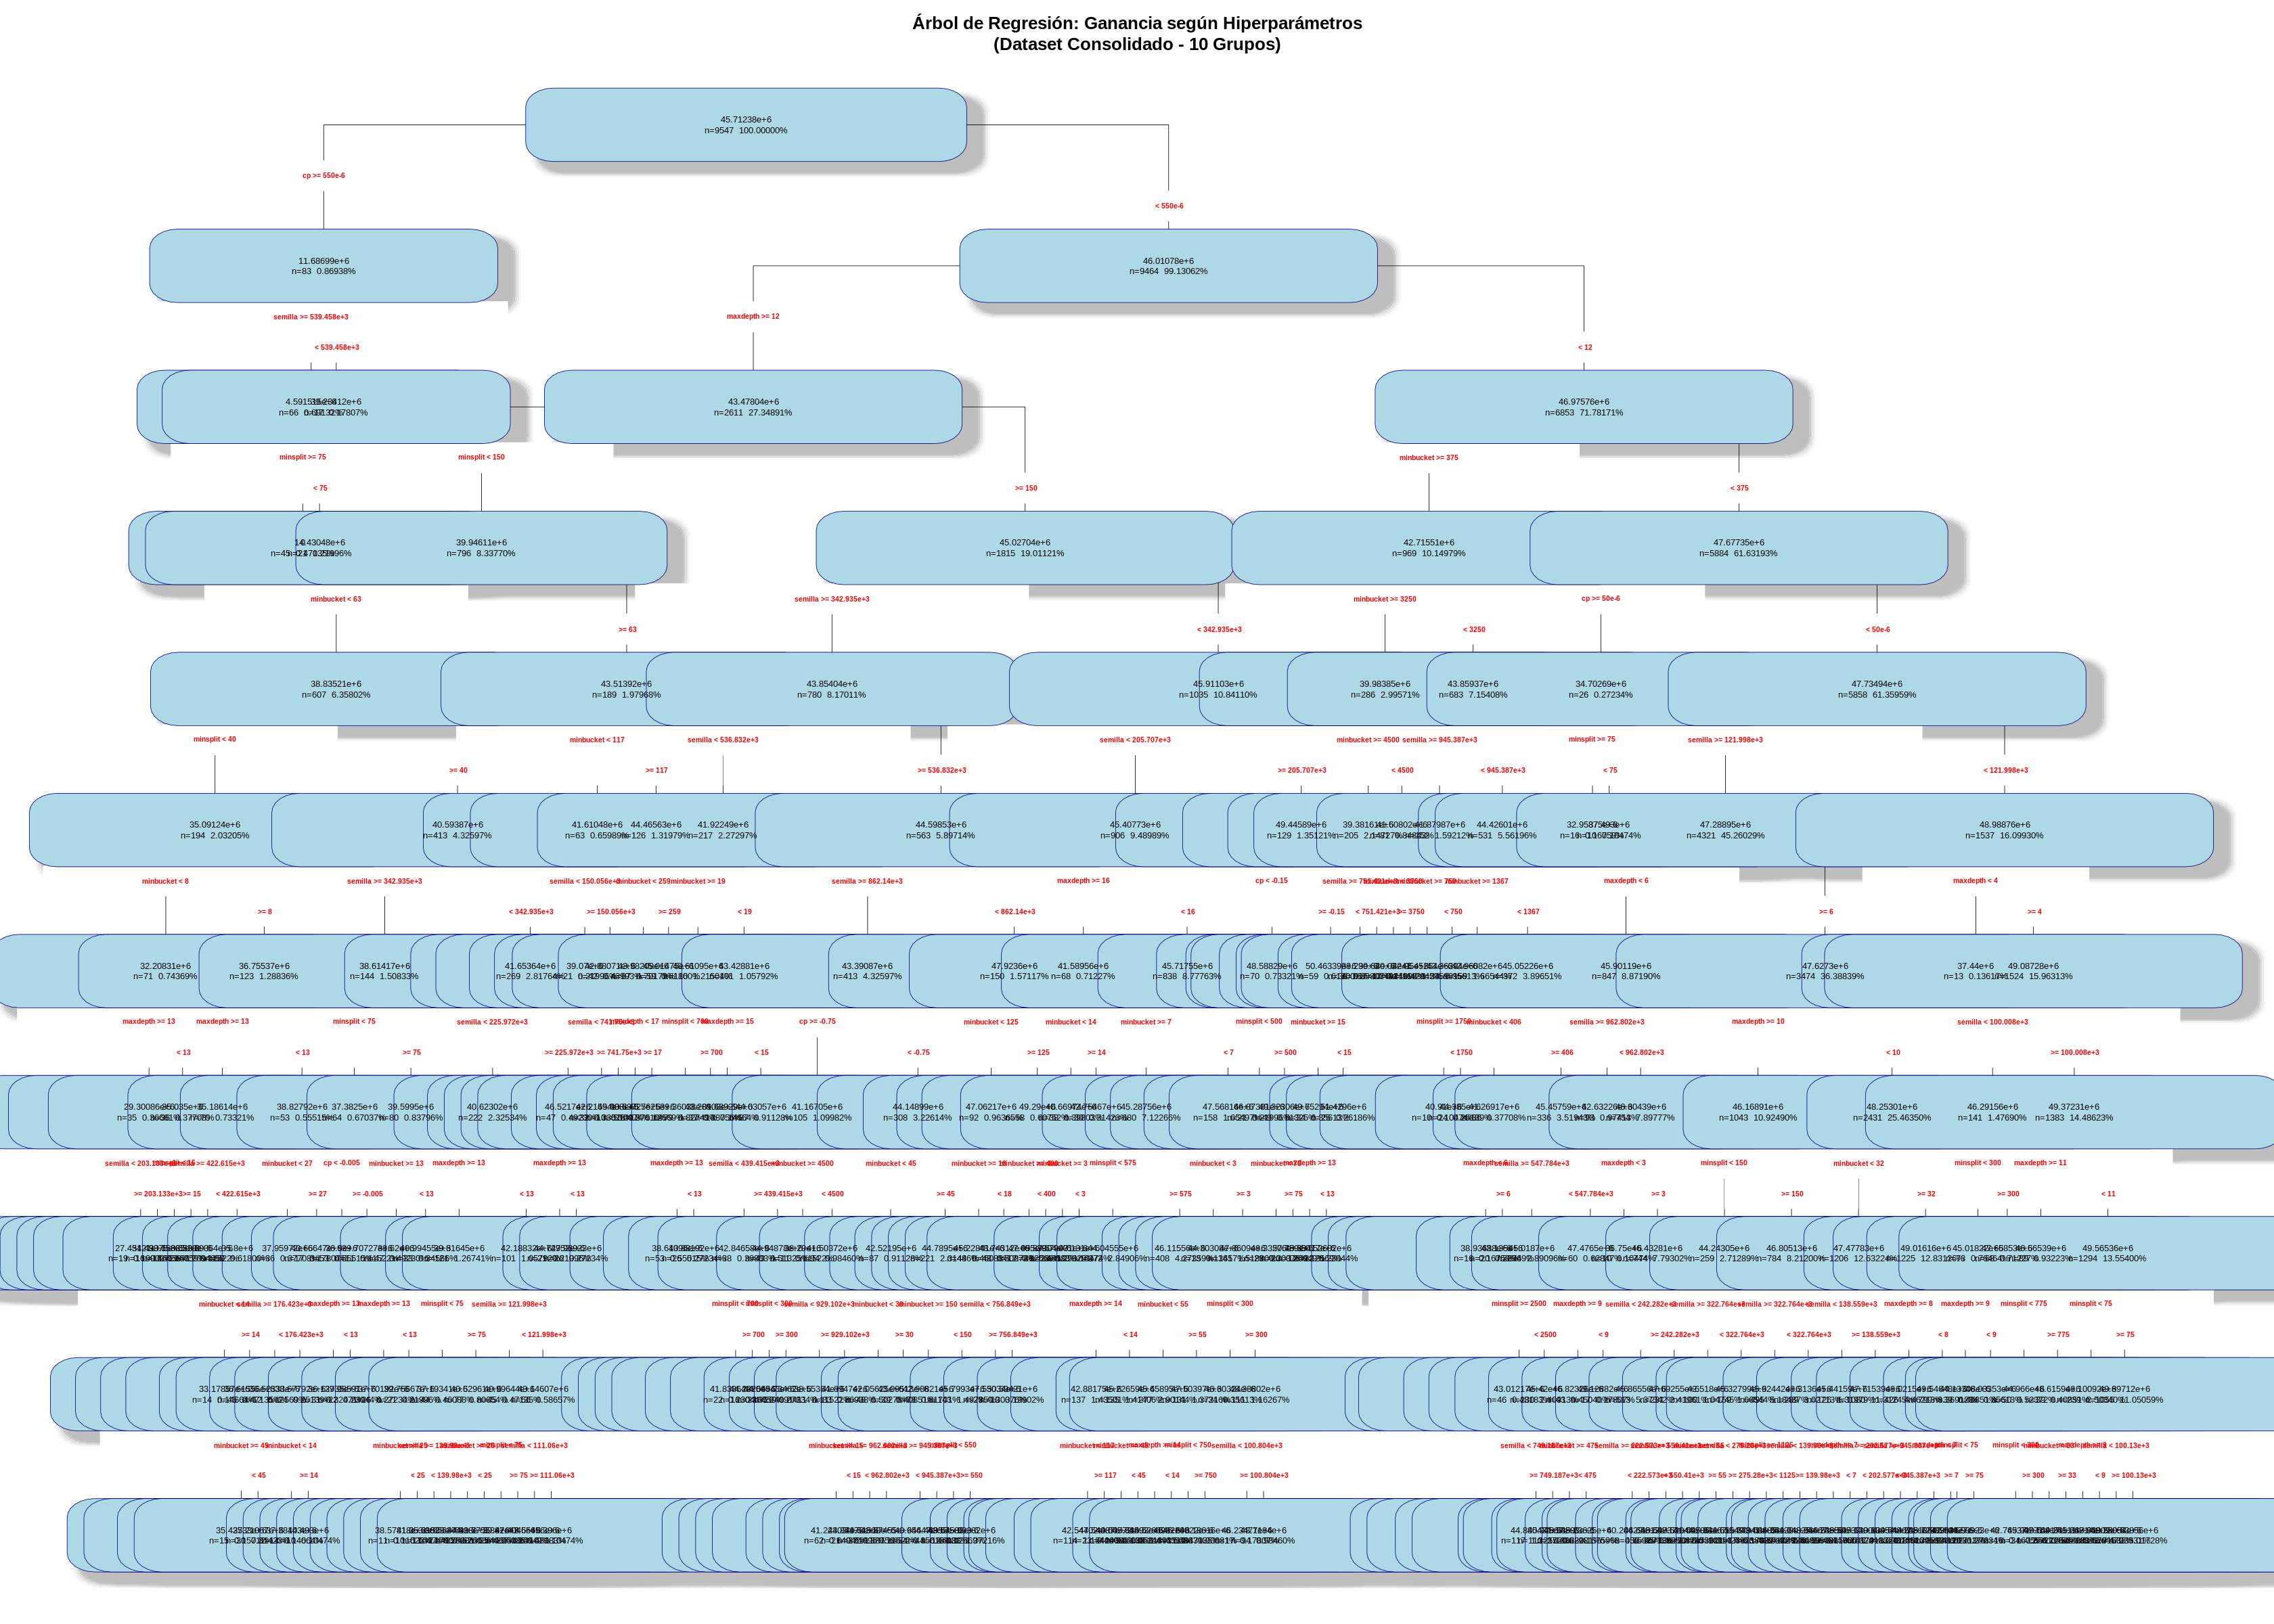

In [ ]:
# ============================================
# VISUALIZACIÓN DEL ÁRBOL
# ============================================

cat("\n============================================\n")
cat("GENERANDO VISUALIZACIÓN DEL ÁRBOL\n")
cat("============================================\n\n")

# Configurar tamaño del gráfico
options(repr.plot.width=28, repr.plot.height=20)

# Grafico el árbol
prp(modelo,
    extra = 101,          # Muestra n y media
    digits = 0,           # Sin decimales en ganancia
    branch = 1,
    type = 4,
    varlen = 0,
    faclen = 0,
    cex = 0.65,           # Tamaño de letra
    cex.main = 1.3,       # Tamaño del título
    box.col = "lightblue",
    border.col = "darkblue",
    shadow.col = "gray",
    split.col = "red",
    split.cex = 0.8,
    main = "Árbol de Regresión: Ganancia según Hiperparámetros\n(Dataset Consolidado - 10 Grupos)"
)


In [ ]:
# ============================================
# PREDICCIÓN Y EVALUACIÓN
# ============================================

cat("\n\n============================================\n")
cat("EVALUACIÓN DEL MODELO\n")
cat("============================================\n\n")

# Predicciones en TRAIN
pred_train <- predict(modelo, newdata = dtrain)
dtrain[, pred_ganancia := pred_train]

# Predicciones en TEST
pred_test <- predict(modelo, newdata = dtest)
dtest[, pred_ganancia := pred_test]

# Función para calcular métricas
calcular_metricas <- function(real, pred) {
  mae <- mean(abs(real - pred))
  rmse <- sqrt(mean((real - pred)^2))
  r2 <- cor(real, pred)^2
  mape <- mean(abs((real - pred) / real)) * 100

  list(mae = mae, rmse = rmse, r2 = r2, mape = mape)
}

# Métricas en TRAIN
metricas_train <- calcular_metricas(dtrain$ganancia_test, dtrain$pred_ganancia)

cat("TRAIN:\n")
cat("  MAE:  ", format(round(metricas_train$mae), big.mark=","), "\n")
cat("  RMSE: ", format(round(metricas_train$rmse), big.mark=","), "\n")
cat("  R²:   ", round(metricas_train$r2, 4), "\n")
cat("  MAPE: ", round(metricas_train$mape, 2), "%\n\n")

# Métricas en TEST
metricas_test <- calcular_metricas(dtest$ganancia_test, dtest$pred_ganancia)

cat("TEST:\n")
cat("  MAE:  ", format(round(metricas_test$mae), big.mark=","), "\n")
cat("  RMSE: ", format(round(metricas_test$rmse), big.mark=","), "\n")
cat("  R²:   ", round(metricas_test$r2, 4), "\n")
cat("  MAPE: ", round(metricas_test$mape, 2), "%\n\n")



EVALUACIÓN DEL MODELO

TRAIN:
  MAE:   1,795,659 
  RMSE:  2,596,362 
  R²:    0.7927 
  MAPE:  NaN %

TEST:
  MAE:   1,930,372 
  RMSE:  2,856,263 
  R²:    0.7402 
  MAPE:  NaN %



GENERANDO GRÁFICOS


ANÁLISIS DE CONFIGURACIONES

TOP 10 MEJORES CONFIGURACIONES (datos reales):
    semilla    cp maxdepth minsplit minbucket ganancia_test Grupo
      <num> <num>    <int>    <num>     <int>         <num> <int>
 1:  304879 -0.10        8      200        30      58870000    10
 2:  304879 -0.05        8      200        30      58870000    10
 3:  304879 -0.01        8      200        30      58870000    10
 4:  304879 -0.10        8      400        30      58760000    10
 5:  304879 -0.05        8      400        30      58760000    10
 6:  304879 -0.01        8      400        30      58760000    10
 7:  304879 -0.10       10      400         5      58510000    10
 8:  304879 -0.05       10      400         5      58510000    10
 9:  304879 -0.01       10      400         5      58510000    10
10:  304879 -0.10        8      200        20      58140000    10


TOP 10 PEORES CONFIGURACIONES (datos reales):
    semilla    cp maxdepth minsplit minbucket ganancia_test Gru

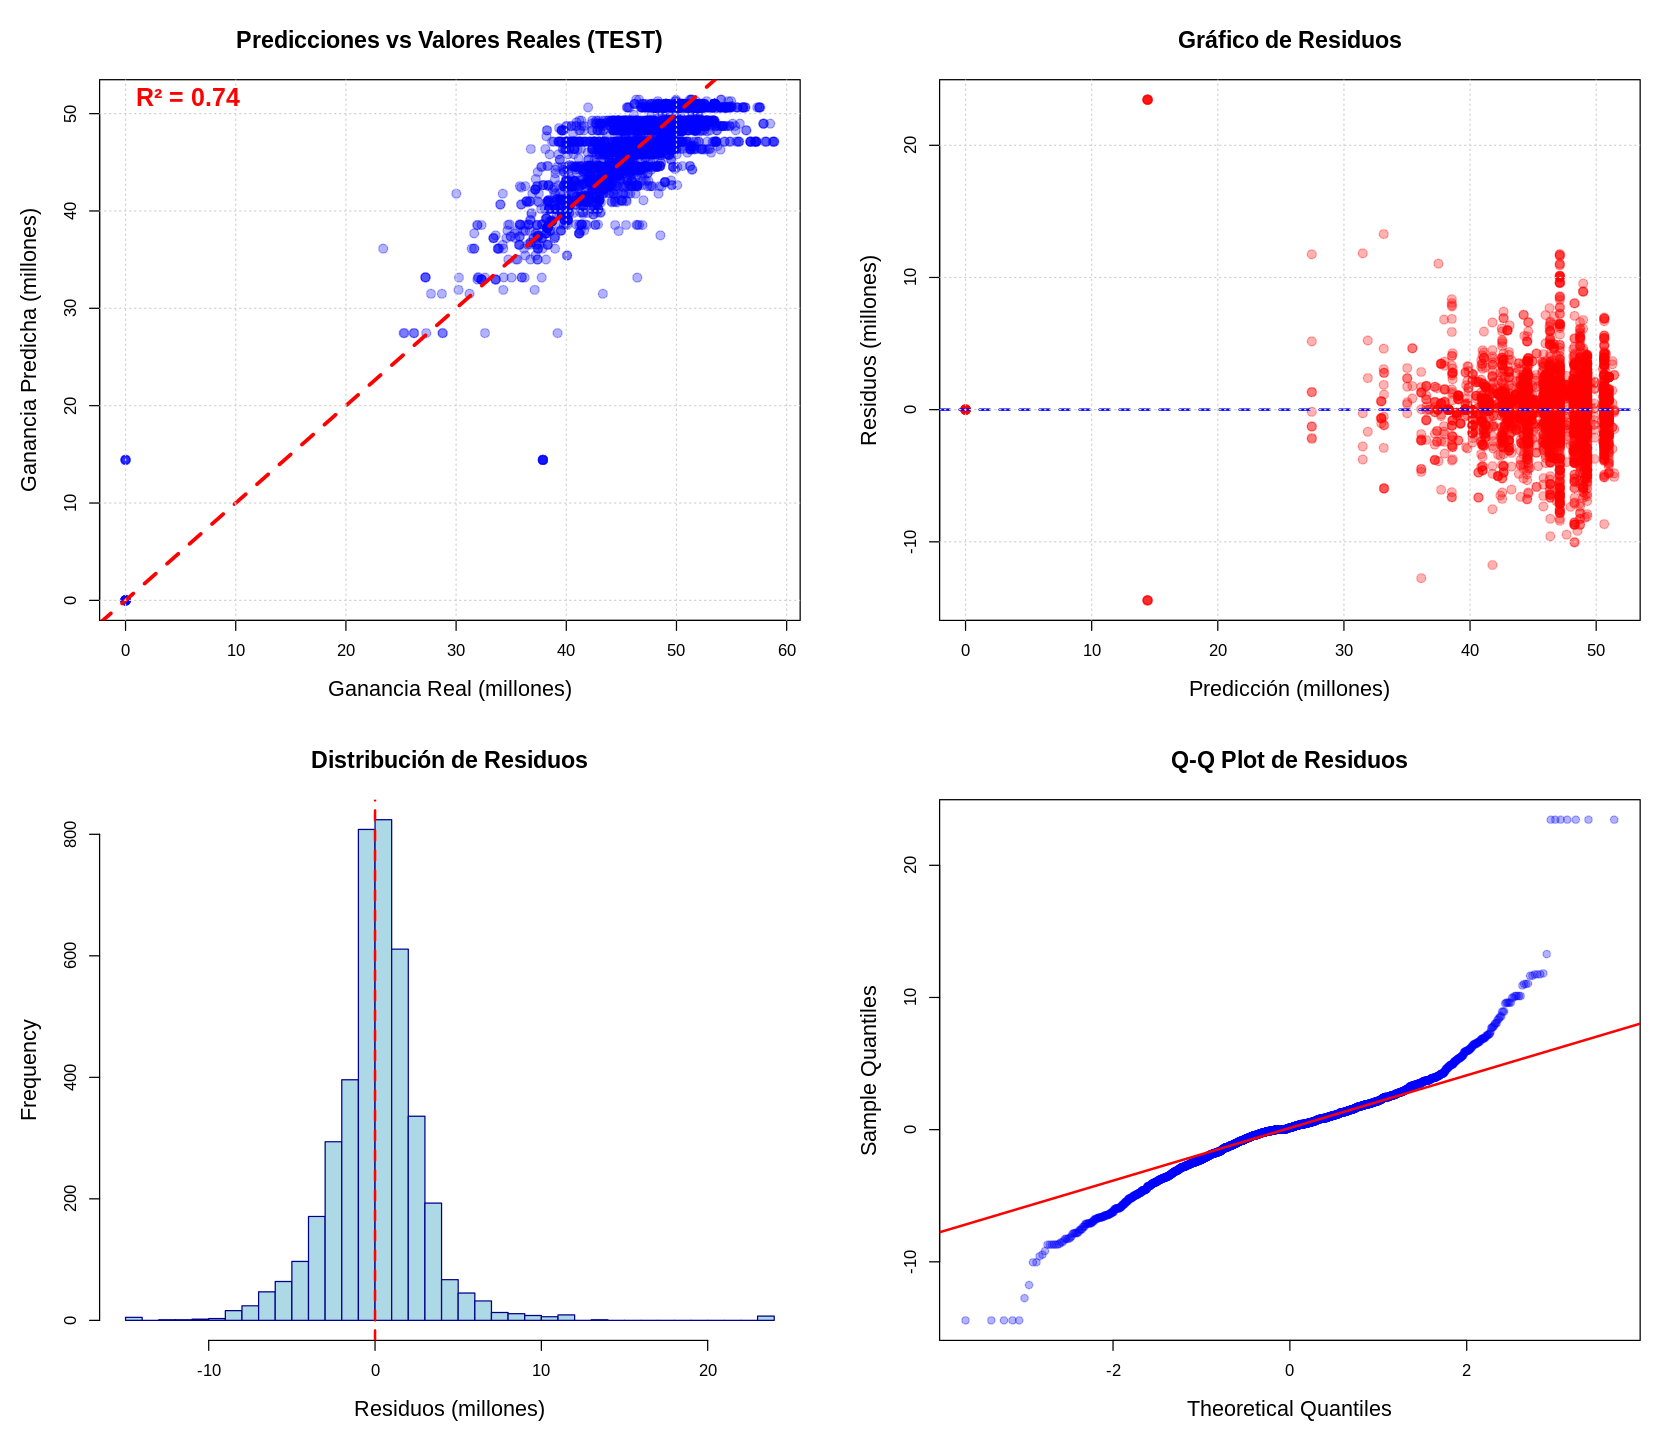

In [ ]:
# ============================================
# VISUALIZACIÓN DE RESULTADOS
# ============================================

cat("============================================\n")
cat("GENERANDO GRÁFICOS\n")
cat("============================================\n\n")

# Gráfico 1: Predicciones vs Reales en TEST
options(repr.plot.width=14, repr.plot.height=12)

par(mfrow=c(2,2), mar=c(5,5,4,2))

# Plot 1: Scatter plot
plot(dtest$ganancia_test / 1e6, dtest$pred_ganancia / 1e6,
     xlab = "Ganancia Real (millones)",
     ylab = "Ganancia Predicha (millones)",
     main = "Predicciones vs Valores Reales (TEST)",
     pch = 19,
     col = rgb(0, 0, 1, 0.3),
     cex = 1.2,
     cex.lab = 1.3,
     cex.main = 1.4)
abline(0, 1, col = "red", lwd = 3, lty = 2)
grid()
text(x = min(dtest$ganancia_test)/1e6,
     y = max(dtest$pred_ganancia)/1e6,
     labels = paste0("R² = ", round(metricas_test$r2, 3)),
     pos = 4, cex = 1.5, col = "red", font = 2)

# Plot 2: Residuos
residuos <- dtest$ganancia_test - dtest$pred_ganancia
plot(dtest$pred_ganancia / 1e6, residuos / 1e6,
     xlab = "Predicción (millones)",
     ylab = "Residuos (millones)",
     main = "Gráfico de Residuos",
     pch = 19,
     col = rgb(1, 0, 0, 0.3),
     cex = 1.2,
     cex.lab = 1.3,
     cex.main = 1.4)
abline(h = 0, col = "blue", lwd = 2, lty = 2)
grid()

# Plot 3: Histograma de residuos
hist(residuos / 1e6,
     breaks = 50,
     col = "lightblue",
     border = "darkblue",
     main = "Distribución de Residuos",
     xlab = "Residuos (millones)",
     cex.lab = 1.3,
     cex.main = 1.4)
abline(v = 0, col = "red", lwd = 2, lty = 2)

# Plot 4: Q-Q plot
qqnorm(residuos / 1e6,
       main = "Q-Q Plot de Residuos",
       pch = 19,
       col = rgb(0, 0, 1, 0.3),
       cex.lab = 1.3,
       cex.main = 1.4)
qqline(residuos / 1e6, col = "red", lwd = 2)

# ============================================
# ANÁLISIS DE MEJORES CONFIGURACIONES
# ============================================

cat("\n============================================\n")
cat("ANÁLISIS DE CONFIGURACIONES\n")
cat("============================================\n\n")

# TOP 10 configuraciones reales
cat("TOP 10 MEJORES CONFIGURACIONES (datos reales):\n")
top10_real <- dataset[order(-ganancia_test)][1:10]
print(top10_real)

cat("\n\nTOP 10 PEORES CONFIGURACIONES (datos reales):\n")
top10_peor <- dataset[order(ganancia_test)][1:10]
print(top10_peor)

# TOP 10 según predicciones
cat("\n\nTOP 10 MEJORES SEGÚN MODELO (test):\n")
top10_pred <- dtest[order(-pred_ganancia)][1:10, .(semilla, cp, maxdepth, minsplit, minbucket,
                                                     ganancia_test, pred_ganancia, Grupo)]
print(top10_pred)


In [ ]:
# ============================================
# GUARDAR RESULTADOS
# ============================================

cat("\n\n============================================\n")
cat("GUARDANDO RESULTADOS\n")
cat("============================================\n\n")

# Guardo predicciones en test
fwrite(dtest[, .(semilla, cp, maxdepth, minsplit, minbucket,
                 ganancia_test, pred_ganancia, Grupo)],
       file = "predicciones_test.csv")

# Guardo métricas
metricas_resumen <- data.table(
  Conjunto = c("TRAIN", "TEST"),
  MAE = c(metricas_train$mae, metricas_test$mae),
  RMSE = c(metricas_train$rmse, metricas_test$rmse),
  R2 = c(metricas_train$r2, metricas_test$r2),
  MAPE = c(metricas_train$mape, metricas_test$mape)
)

fwrite(metricas_resumen, file = "metricas.csv")


# Guardo top 10
fwrite(top10_real, file = "top10_mejores.csv")

cat("Archivos guardados:\n")
cat("  - predicciones_test.csv\n")
cat("  - metricas.csv\n")
cat("  - analisis_grupos.csv\n")
cat("  - top10_mejores.csv\n")

cat("\n============================================\n")
cat("¡ANÁLISIS COMPLETADO!\n")
cat("============================================\n")
cat("\nResumen Final:\n")
cat("  Dataset: 14,473 filas con 10 grupos\n")
cat("  Variables predictoras: semilla, cp, maxdepth, minsplit, minbucket\n")
cat("  Variable objetivo: ganancia_test\n")
cat("  R² en TEST: ", round(metricas_test$r2, 4), "\n")
cat("  MAPE en TEST: ", round(metricas_test$mape, 2), "%\n")
cat("============================================\n")



GUARDANDO RESULTADOS

Archivos guardados:
  - predicciones_test.csv
  - metricas.csv
  - analisis_grupos.csv
  - top10_mejores.csv

¡ANÁLISIS COMPLETADO!

Resumen Final:
  Dataset: 14,473 filas con 10 grupos
  Variables predictoras: semilla, cp, maxdepth, minsplit, minbucket
  Variable objetivo: ganancia_test
  R² en TEST:  0.7402 
  MAPE en TEST:  NaN %
